In [ ]:
!pip install transformers datasets pandas scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate

# Load the dataset with a different encoding
data = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# Select only relevant columns
data = data[['v1', 'v2']]
data.columns = ['label', 'text']

# Convert labels to binary values: 'ham' -> 0, 'spam' -> 1
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Display the first 15 rows of the dataset in a beautiful table format
print(tabulate(data.head(15), headers='keys', tablefmt='pretty', showindex=False))

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)




+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| label |                                                                                                 text                                                                                                 |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   0   |                                           Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                            |
|   0   |                                                                                    Ok lar... Joking wif u oni...                                          

In [ ]:
from transformers import AutoTokenizer

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SpamDataset(train_encodings, list(train_labels))
test_dataset = SpamDataset(test_encodings, list(test_labels))


In [ ]:
from transformers import AutoModelForSequenceClassification

# Load pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install datasets
import torch
from transformers import TrainingArguments, Trainer, AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from datasets import Dataset

# Load your custom dataset (spam.csv) using pandas
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# Drop the columns that are not needed (those starting with 'Unnamed')
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Remove rows with NaN values
df = df.dropna()

# Inspect the first few rows to check the structure of the dataset
print(df.head())

# Rename the columns for clarity (if needed)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

# Convert 'ham' to 0 and 'spam' to 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Split your dataset into training and test sets
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
test_df = df.drop(train_df.index)  # The rest is for testing

# Convert pandas DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset (using 'text' for the text column)
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Apply the tokenization to both train and test datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Initialize the model (BertForSequenceClassification with 2 labels)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Use eval_strategy instead of evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Use a small batch size for CPU
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=5,
    report_to="wandb",  # Report to Weights and Biases
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=1)
    # Convert predictions to a NumPy array
    predictions = predictions.cpu().numpy()
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


Map:   0%|          | 0/4458 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.121000,0.062513,0.985637,0.973154,0.923567,0.947712
2,0.000200,0.079056,0.989228,0.980132,0.942675,0.961039
3,0.000100,0.089920,0.988330,0.973684,0.942675,0.957929


TrainOutput(global_step=1674, training_loss=0.028657806706956248, metrics={'train_runtime': 1467.4662, 'train_samples_per_second': 9.114, 'train_steps_per_second': 1.141, 'total_flos': 3518847254384640.0, 'train_loss': 0.028657806706956248, 'epoch': 3.0})

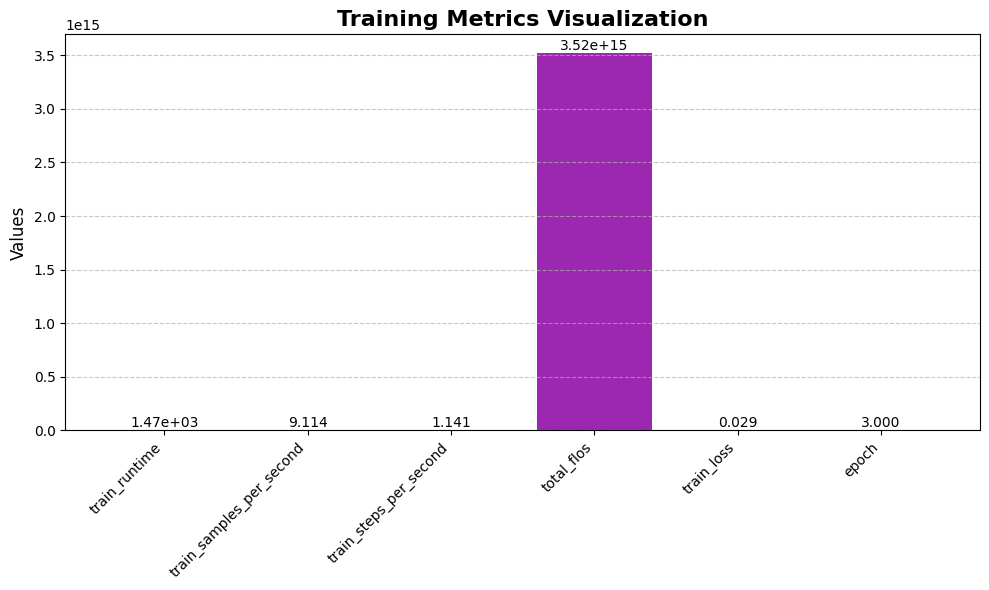

In [ ]:
import matplotlib.pyplot as plt

# Updated Data from TrainOutput and metrics for plotting
metrics = {
    'train_runtime': 1467.4662,  # Updated value from TrainOutput
    'train_samples_per_second': 9.114,
    'train_steps_per_second': 1.141,
    'total_flos': 3518847254384640.0,
    'train_loss': 0.028657806706956248,
    'epoch': 3.0
}

# Data for plotting
categories = list(metrics.keys())
values = list(metrics.values())

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(categories, values, color=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0', '#FF5722', '#00BCD4'])

# Customizing the plot
plt.title("Training Metrics Visualization", fontsize=16, fontweight='bold')
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')

# Adding value annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2e}' if height > 1000 else f'{height:.3f}',
             ha='center', va='bottom', fontsize=10, color='black')

# Show gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
